$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$

$\newcommand{\R}{\bb{R}}$

$\newcommand{\ip}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$

$\newcommand{\der}[2]{\frac{\mathrm{d} #1 }{\mathrm{d} #2 }}$
$\newcommand{\derp}[2]{\frac{\partial #1 }{\partial #2 }}$

# Finite Dimensional Koopman Bilinear System

Consider a nonlinear dynamical system that allows an exact finite dimensional Koopman canonical transform such that the control-affine dynamics can be transformed to a bilinear system. Consider the dynamical system 

\begin{equation}
\mb{\dot{x}}=\mb{f}_0(\mb x) + \mb f_1 ( \mb x) u_1 + \mb f_2(\mb x) u_2, 
\end{equation}

where we for this example choose $\mb f_0, \mb f_1$ as follows:

\begin{equation}
\mb f_0(\mb x) = \begin{bmatrix} x_3 \\ x_4 \\ \lambda x_3 \\ \mu x_4 + (2 \lambda - \mu) c x_3^2 \end{bmatrix}, \qquad
\mb f_1(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix}, \qquad
\mb f_2(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 0 \\ x_1+1 \end{bmatrix}, 
\end{equation}   

and $\lambda, \mu, c \in \mathbb{R}$ are scalar parameters of the system. Setting $ \mb x = [q_1 \, q_2 \, \dot{q_1} \, \dot{q_2}]^T$, 
these equations of motion can be expressed as robotic dynamics of the form $\mb{D}(\mb{q})\ddot{\mb{q}} + \mb{C}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \mb{G}(\mb{q}) = \mb{B}\mb{u}$, where $\mb D$ is the inertia matrix, $\mb C$ is the matrix of Coriolis terms, $\mb G$ is the matrix of gravitational terms, and $\mb B$ is the static actuation matrix. Rewriting $\mb f_0, \mb f_1, \mb f_2$ in terms of $\mb D, \mb C, \mb G,$ and $\mb B$ yield



\begin{equation}
\mb D(\mb q) = \begin{bmatrix} 1 & 0\\ 0 &  \frac{1}{q_1+1} \end{bmatrix}, 
\qquad \mb C(\mb q, \mb{\dot{q}}) = -\begin{bmatrix} \lambda & 0 \\ \frac{1}{q_1 + 1}(2 \lambda - \mu) c \dot{q}_1 & \frac{1}{q_1 +1} \mu \end{bmatrix}, \qquad 
\mb G(\mb q) = \begin{bmatrix} 0 \\ 0 \end{bmatrix} 
\qquad \mb B = \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix},
\end{equation}

In [1]:
import numpy as np
import sys
sys.path.append('../../../')

# Define experiment parameters

In [2]:
from core.dynamics import RoboticDynamics

class FiniteDimKoopSys(RoboticDynamics):
    def __init__(self, lambd, mu, c):
        RoboticDynamics.__init__(self, 2, 2)
        self.params = lambd, mu, c
    
    def D(self, q):
        return np.array([[1, 0],[0, (q[0]+1)**(-1)]])
    
    def C(self, q, q_dot):
        labmd, mu, c = self.params
        return -np.array([[lambd, 0], [(q[0]+1)**(-1)*(2*lambd - mu)*c*q_dot[0], (q[0]+1)**(-1)*mu]])
    
    def G(self, q):
        return np.array([0, 0])
    
    def B(self, q):
        return np.array([[1, 0], [0, 1]])
    
class FiniteDimKoopSysDiscrete(FiniteDimKoopSys):
    def __init__(self, lambd, mu, c, dt):
        FiniteDimKoopSys.__init__(self, lambd, mu, c)
        self.dt = dt

    def eval_dot(self, x, u, t):
        return x + self.dt*self.drift(x, t) + self.dt*np.dot(self.act(x, t),u)

    def get_linearization(self, x0, x1, u0, t):
        lambd, mu, c = self.params
        A_lin = np.eye(self.n) + self.dt*np.array([[0, 0, 1, 0],
                                            [0, 0, 0, 1],
                                            [0, 0, lambd, 0],
                                            [u0[1], 0, 2*(2*lambd-mu)*c*x0[2], mu]])

        B_lin = self.dt*np.array([[0, 0],
                          [0, 0],
                          [1, 0],
                          [0, x0[0]+1]])

        if x1 is None:
            x1 = A_lin@x0 + B_lin@u0

        f_d = self.eval_dot(x0,u0,t)
        r_lin = f_d - x1

        return A_lin, B_lin, r_lin

n, m = 4, 2
lambd, mu, c = .3, .2, -.5
finite_dim_koop_sys = FiniteDimKoopSys(lambd, mu, c)

In [3]:
from koopman_core.dynamics import LinearLiftedDynamics

A_lin = np.array([[0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [0, 0, lambd, 0],
                  [0, 0, 0, mu]])
B_lin = np.array([[0, 0],
                  [0, 0],
                  [1, 0],
                  [0, 1]])
dt = 1e-2
linearized_sys = LinearLiftedDynamics(A_lin, B_lin, np.eye(n), lambda x: x)

# MPC parameters:
umax = np.array([7.5, 7.5])
umin = -umax
xmax = np.array([6., 6., 5., 5.])
xmin = -xmax
Q_mpc = 1*np.diag([1, 1, 1e-1, 1e-1])
QN_mpc = 1e4*np.eye(n)
R_mpc = np.eye(m)
traj_duration = 2
traj_length = int(traj_duration/dt)

# Design trajectory:
x0 = np.array([0., 0., 0., 0.])
set_pt = np.array([5., 3., 0., 0.])
term_constraint = True

# Define initial solution for SQP algorithm:
x_init = np.linspace(x0, set_pt, int(traj_length)+1)
u_init = np.ones((m,traj_length)).T

# Construct Koopman bilinear form of the system

As a result of the careful construction of this system, there exists a Koopman canonical transform, $\mb z = T(\mb x)$ that exactly transforms the control-affine dynamics into a bilinear system. Consider the transformation:

\begin{equation}
    T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 
    \phi_1(\mb q, \mb{\dot{q}})\\
    \phi_2(\mb q, \mb{\dot{q}})\\
    \phi_3(\mb q, \mb{\dot{q}})\\
    \phi_4(\mb q, \mb{\dot{q}})\\
    \phi_5(\mb q, \mb{\dot{q}})\\
    \phi_6(\mb q, \mb{\dot{q}})\\
    \end{bmatrix}
    = \begin{bmatrix} 
    1\\
    q_1 - \frac{1}{\lambda}\dot{q}_1\\
    q_2 - \frac{1}{\mu} \dot{q}_2 + \frac{(2 \lambda - \mu)c}{2\lambda \mu} \dot{q}_1^2\\
    \dot{q}_1\\
    \dot{q}_2 - c \dot{q}_1^2\\
    \dot{q}_1^2\\
    \end{bmatrix},
\end{equation}

where $\phi_1, \phi_2, \phi_3, \phi_4, \phi_5, \phi_6$ are eigenfunctions of the Koopman operator associated with the drift 
vector field $\mb f_0$. The matrix with the eigenvalue associated with the i-th eigenfunction on the i-th diagonal 
element is $F=\text{diag}(0, 0, \lambda, \mu, 2 \lambda, 0)$. Then, to reformulate the dynamics we have: 

\begin{equation} 
L_{\mb f_1} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 0\\ -\frac{1}{\lambda}\\ \frac{(2\lambda - \mu)c}{\lambda \mu}\dot{q}_1\\ 1 \\ -2c\dot{q}_1 \\ 2\dot{q_1} \end{bmatrix}, \qquad 
L_{\mb f_2} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 0 \\ 0\\ -\frac{1}{\mu}(q_1 + 1)\\0 \\ q_1 + 1 \\ 0 \end{bmatrix} 
\end{equation}

and the dynamics can be equivalently transformed to a bilinear form $\mb{\dot{z}} = F \mb z + G_1\mb z u_1 + G_2\mb z u_2$ with 

\begin{equation}
F = \begin{bmatrix} 
0 &0 & 0 & 0 & 0 & 0\\  
0 & 0 & 0 & 0 & 0 & 0\\
0 &0 & 0 & 0 & 0 & 0\\
0 &0 & 0 & \lambda & 0 & 0\\
0 &0 & 0 & 0 & \mu & 0 \\
0 &0 & 0 & 0 & 0 & 2 \lambda\\
\end{bmatrix}, \qquad 
G_1 = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0\\
-\frac{1}{\lambda}& 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & \frac{(2\lambda - \mu)c}{\lambda \mu} & 0 & 0\\
1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & -2c & 0 & 0\\
0 & 0 & 0 & 2 & 0 & 0\\  
\end{bmatrix}
, \qquad 
G_2 = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 &  0 & 0 & 0 & 0\\
 -\frac{1}{\mu} & -\frac{1}{\mu} & 0 &  -\frac{1}{\lambda \mu} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & \frac{1}{\lambda} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\  
\end{bmatrix}
\end{equation}

In [4]:
from koopman_core.dynamics import BilinearLiftedDynamics

F = np.array([[0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, lambd, 0, 0],
              [0, 0, 0, 0, mu, 0],
              [0, 0, 0, 0, 0, 2*lambd]])
G_1 = np.array([[0, 0, 0, 0, 0, 0],
                [-1/lambd, 0, 0, 0, 0, 0],
                [0, 0, 0, (2*lambd - mu)*c/(lambd*mu), 0, 0],
                [1, 0, 0, 0, 0, 0], 
                [0, 0, 0, -2*c, 0, 0], 
                [0, 0, 0, 2, 0, 0]])
G_2 = np.array([[0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [-1/mu, -1/mu, 0, -1/(lambd*mu), 0, 0],
                [0, 0, 0, 0, 0, 0], 
                [1, 1, 0, 1/lambd, 0, 0], 
                [0, 0, 0, 0, 0, 0]])
G = [G_1, G_2]
phi_fun = lambda x: np.array([1,
                            x[0,0] - 1/lambd*x[0,2],
                            x[0,1] - 1/mu*x[0,3] + (2*lambd - mu)*c/(2*lambd*mu)*x[0,2]**2,
                            x[0,2],
                            x[0,3] - c*x[0,2]**2,
                            x[0,2]**2])
phi_fun_grad = lambda x: np.array([[0., 0., 0., 0.]
                                   [1., 0., -1/lambd, 0.],
                                   [0., 1., (2*lambd-mu)*c/(lambd*mu)*x[0,2], -1/mu],
                                   [0., 0., 1., 0.],
                                   [0., 0., -2*c*x[0,2], 1.],
                                   [0., 0., 2*x[0,2], 0.]])

C_q = np.array([[0, 1, 0, 1/lambd, 0, 0],
                [0, 0, 1, 0, 1/mu, c/mu - ((2*lambd - mu)*c)/(2*lambd*mu)]])
C_qdot = np.array([[0, 0, 0, 1, 0, 0],
                   [0, 0, 0, 0, 1, c]])
C = np.concatenate((C_q, C_qdot), axis=0)
n_koop = 6

koop_bilinear_sys = BilinearLiftedDynamics(n_koop, m, F, G, C, phi_fun)

#### Verify that the Koopman Bilinear Form model and control-affine model are equivalent

To verify that the models are in fact equivalent we sample a random control sequence and simulate both models forward with the same control sequence. As can be seen below, the resulting trajectories are equivalent.

[5.54286675e-05 4.80374580e-05 1.10912791e-02 9.61074286e-03]
[0.00013641 0.00028181 0.005102   0.03715426]
[0.00022312 0.00065971 0.01224384 0.0384258 ]
[0.00035668 0.00105692 0.01446958 0.04101635]
[0.00058021 0.00146278 0.03024412 0.04015582]
[0.00079118 0.00187703 0.01193968 0.04269579]
[0.00090965 0.00226196 0.01175546 0.03428593]
[0.00101076 0.00262861 0.00846489 0.0390453 ]
[0.00112857 0.00297866 0.0151004  0.03096258]
[0.00134454 0.00328711 0.02809895 0.03072802]
[0.00167777 0.00360826 0.03855271 0.03350135]
[0.00199512 0.00389237 0.02491131 0.02331718]
[0.00217531 0.00409374 0.01111828 0.01695426]
[0.00235421 0.00432526 0.02466896 0.02935483]
[0.0025667  0.00461953 0.01782564 0.02949871]
[0.00278342 0.0048932  0.0255229  0.02523425]
[0.00305408 0.00514409 0.02860969 0.02494418]
[0.00343932 0.00539365 0.04844824 0.02496664]
[0.00391806 0.00565975 0.04729993 0.02825453]
[0.00436982 0.00590335 0.04304943 0.0204623 ]
[0.00485262 0.00608444 0.05351614 0.01575424]
[0.00542555 0.0062

[ 1.         -0.20769832 -0.33841667  0.06562589  0.07045674  0.00430676]
[ 1.         -0.23378068 -0.32111453  0.07365952  0.06731571  0.00542573]
[ 1.         -0.21981881 -0.25069614  0.06968598  0.05325254  0.00485614]
[ 1.         -0.26555057 -0.2025328   0.08363548  0.04406773  0.00699489]
[ 1.         -0.2847543  -0.30239761  0.08965654  0.06431545  0.00803829]
[ 1.         -0.31782169 -0.28314515  0.09986102  0.06090349  0.00997222]
[ 1.         -0.34141752 -0.29925954  0.10725043  0.06449611  0.01150266]
[ 1.         -0.31301633 -0.25977886  0.09903952  0.05642794  0.00980883]
[ 1.         -0.29801397 -0.26344631  0.09482962  0.05712955  0.00899266]
[ 1.         -0.32591492 -0.21013169  0.10349738  0.04684727  0.01071171]
[ 1.         -0.36361147 -0.27696437  0.11513429  0.06073343  0.0132559 ]
[ 1.         -0.35439537 -0.25972403  0.11271123  0.0572984   0.01270382]
[ 1.         -0.35631937 -0.18934687  0.11362794  0.04334539  0.01291131]
[ 1.         -0.33851364 -0.25367976  

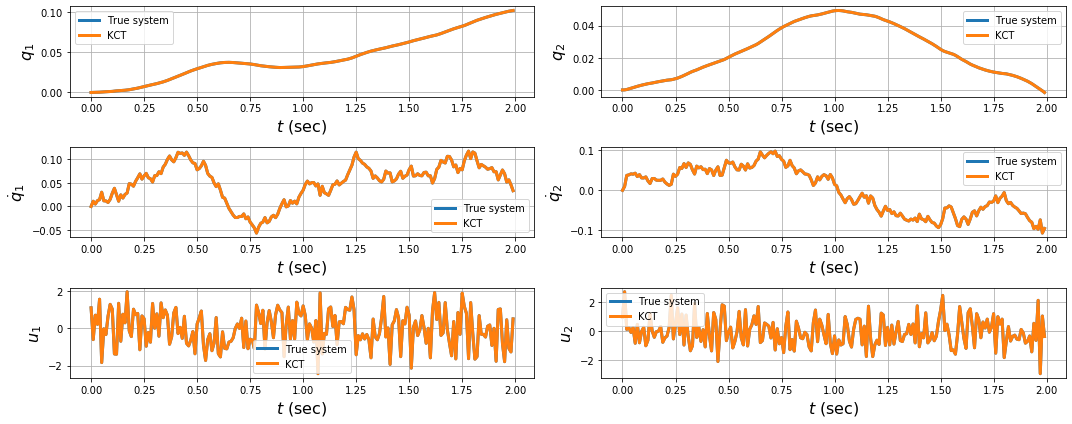

In [5]:
from matplotlib.pyplot import subplots, tight_layout, show
from koopman_core.controllers.openloop_controller import OpenLoopController

ol_controller = OpenLoopController(finite_dim_koop_sys, np.random.normal(size=(2,200)).T, np.arange(0,200)*dt)
z0 = phi_fun(x0.reshape((1,-1)))
xs, us = finite_dim_koop_sys.simulate(x0, ol_controller, np.arange(0,201)*dt)
zs_koop, us_koop = koop_bilinear_sys.simulate(z0, ol_controller, np.arange(0,201)*dt)
xs_koop = np.dot(C, zs_koop.T)

_, axs = subplots(3, 2, figsize=(15, 6))
ylabels = ['$q_1$', '$q_2$', '$\\dot{q}_1$', '$\\dot{q}_2$', '$u_1$', '$u_2$']

for ax, data_fb, data_koop, ylabel in zip(axs.flatten(), np.vstack((xs[:-1,:].T, us.T)), np.vstack((xs_koop[:,:-1], us_koop.T)), ylabels):
    ax.plot(np.arange(0,200)*dt, data_fb, linewidth=3, label='True system')
    ax.plot(np.arange(0,200)*dt, data_koop, linewidth=3, label='KCT')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.grid()
    ax.set_xlabel('$t$ (sec)', fontsize=16)
    ax.legend()
    
tight_layout()
show()

# Design model predictive controllers

#### Linear model predictive controller

In [6]:
from koopman_core.controllers import MPCController

controller_lmpc = MPCController(linearized_sys, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt, terminal_constraint=term_constraint, add_slack=True)

#### Bilinear model predictive controller

In [7]:
from koopman_core.controllers import NonlinearMPCController, BilinearMPCController

# Define rough discrete-time model:
A_d = np.eye(n_koop) + koop_bilinear_sys.A*dt
B_d = [b*dt for b in koop_bilinear_sys.B]
kbf_d = BilinearLiftedDynamics(n_koop, m, A_d, B_d, C, koop_bilinear_sys.basis, continuous_mdl=False, dt=dt)

# Define kbf controller:
controller_knmpc = BilinearMPCController(kbf_d, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt, terminal_constraint=term_constraint)
z0 = phi_fun(x0.reshape((1,-1)))
z_init = np.array([phi_fun(x.reshape((1,-1))) for x in x_init])
controller_knmpc.construct_controller(z_init, u_init)

#### Nonlinear model predictive controller

In [8]:
finite_dim_koop_sys_d = FiniteDimKoopSysDiscrete(lambd, mu, c, dt)
controller_nmpc = NonlinearMPCController(finite_dim_koop_sys_d, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt, terminal_constraint=term_constraint)
controller_nmpc.construct_controller(x_init, u_init)

# Evaluate performance of controllers for trajectory generation

#### Design trajectories with the constructed MPCs

In [9]:
max_iter = 50

controller_lmpc.eval(x0, 0)
xr_lmpc = controller_lmpc.parse_result()
ur_lmpc = controller_lmpc.get_control_prediction()

controller_knmpc.solve_to_convergence(z0, 0., z_init, u_init, max_iter=max_iter)
xr_knmpc = koop_bilinear_sys.C@controller_knmpc.get_state_prediction().T
ur_knmpc = controller_knmpc.get_control_prediction().T

controller_nmpc.solve_to_convergence(x0, 0., x_init, u_init, max_iter=max_iter)
xr_nmpc = controller_nmpc.get_state_prediction().T
ur_nmpc = controller_nmpc.get_control_prediction().T

#### Simulate designed trajectories open-loop

In [10]:
from koopman_core.controllers import OpenLoopController
t_eval = np.arange(0,traj_length+1)*dt
ol_controller_lmpc = OpenLoopController(finite_dim_koop_sys, ur_lmpc.T, t_eval[:-1])
xs_lmpc, us_lmpc = finite_dim_koop_sys.simulate(x0, ol_controller_lmpc, t_eval)
xs_lmpc, us_lmpc = xs_lmpc.T, us_lmpc.T

ol_controller_knmpc = OpenLoopController(finite_dim_koop_sys, ur_knmpc.T, t_eval[:-1])
xs_knmpc, us_knmpc = finite_dim_koop_sys.simulate(x0, ol_controller_knmpc, t_eval)
xs_knmpc, us_knmpc = xs_knmpc.T, us_knmpc.T

ol_controller_nmpc = OpenLoopController(finite_dim_koop_sys, ur_nmpc.T, t_eval[:-1])
xs_nmpc, us_nmpc = finite_dim_koop_sys.simulate(x0, ol_controller_nmpc, t_eval)
xs_nmpc, us_nmpc = xs_nmpc.T, us_nmpc.T

[0.00037542 0.00024885 0.07512159 0.04978714]
[0.00150318 0.00099227 0.15046882 0.09891817]
[0.00338555 0.0022238  0.22604238 0.14740943]
[0.00602479 0.00393711 0.30184295 0.19527547]
[0.00942317 0.00612601 0.3778712  0.24252906]
[0.01358297 0.00878443 0.45412785 0.28918119]
[0.01850619 0.0119064  0.53055293 0.33524114]
[0.02419215 0.01548605 0.60667824 0.38071704]
[0.03063392 0.01951757 0.68171194 0.4256169 ]
[0.03782059 0.02399525 0.75566078 0.46994852]
[0.04574137 0.02891342 0.82853144 0.51371859]
[0.0543855  0.03426651 0.90033058 0.5569328 ]
[0.0637423  0.04004899 0.9710648  0.59959586]
[0.07380116 0.04625535 1.04074066 0.64171148]
[0.08455151 0.05288014 1.10936469 0.68328247]
[0.09598288 0.05991793 1.17694335 0.72431071]
[0.10808485 0.06736329 1.24348308 0.76479722]
[0.12084705 0.0752108  1.30899027 0.80474216]
[0.1342592  0.08345505 1.37347125 0.84414487]
[0.14831106 0.0920906  1.43693231 0.88300391]
[0.16299246 0.10111202 1.49937971 0.92131705]
[0.1782933  0.11051382 1.56081964 

[0.00036581 0.00013234 0.07319947 0.0264766 ]
[0.0014571  0.00052729 0.14509273 0.05252065]
[0.00326091 0.00118062 0.21570528 0.07815497]
[0.00576457 0.00208837 0.28506198 0.1034013 ]
[0.00895563 0.00324674 0.35318357 0.12828045]
[0.01282184 0.00465217 0.42009118 0.15281234]
[0.01735117 0.00630128 0.48580814 0.17701597]
[0.02253183 0.00819088 0.55035706 0.2009093 ]
[0.02835226 0.01031795 0.61375992 0.22450939]
[0.03480109 0.01267963 0.67603809 0.24783244]
[0.04186719 0.01527323 0.73721228 0.27089389]
[0.04953962 0.01809621 0.79730264 0.29370844]
[0.05780763 0.02114618 0.85632875 0.31629015]
[0.06666067 0.02442086 0.91430962 0.33865243]
[0.0760884  0.02791814 0.97126375 0.36080816]
[0.08608062 0.031636   1.02720908 0.38276963]
[0.09662735 0.03557256 1.08216308 0.40454866]
[0.10771874 0.03972605 1.13614273 0.42615656]
[0.11934514 0.04409483 1.18916452 0.44760421]
[0.13149706 0.04867732 1.24124449 0.46890202]
[0.14416514 0.0534721  1.29239824 0.49006   ]
[0.15734021 0.0584778  1.34264094 

[0.24900061 0.08796077 1.82856537 0.65334724]
[0.26757213 0.09460951 1.88576674 0.676407  ]
[0.28671046 0.10148855 1.94192686 0.69941066]
[0.30640524 0.10859739 1.997057   0.72236672]
[0.32664623 0.11593559 2.0511681  0.74528342]
[0.34742329 0.12350279 2.10427083 0.76816866]
[0.36872639 0.13129872 2.15637554 0.79103001]
[0.3905456  0.13932317 2.2074923  0.8138747 ]
[0.41287109 0.14757601 2.25763089 0.8367096 ]
[0.43569313 0.15605718 2.30680081 0.85954121]
[0.45900207 0.16476667 2.35501133 0.88237562]
[0.48278837 0.17370455 2.40227141 0.90521852]
[0.50704256 0.18287091 2.4485898  0.92807516]
[0.53175527 0.19226592 2.49397497 0.95095038]
[0.55691721 0.20188979 2.53843517 0.97384853]
[0.58251916 0.21174277 2.5819784  0.9967735 ]
[0.60855201 0.22182515 2.62461246 1.01972871]
[0.63500669 0.23213723 2.6663449  1.04271708]
[0.66187423 0.24267937 2.70718305 1.06574102]
[0.68914572 0.25345193 2.74713405 1.08880242]
[0.71681231 0.26445528 2.78620483 1.11190264]
[0.74486525 0.27568983 2.8244021  

#### Plot/analyze the results

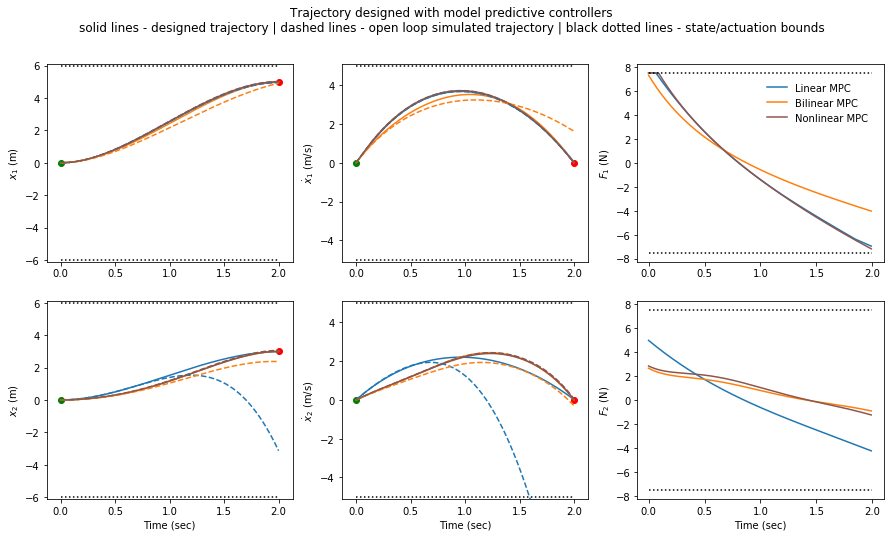

Quadratic cost (normalized by NMPC cost) of designed and realized trajectories designed with each MPC:

                        Designed trajectory    Realized trajectory
--------------------  ---------------------  ---------------------
Linear MPC                         1.18108               547.005
Koopman bilinear MPC               0.495652                7.55153
Nonlinear MPC                      1                       1


In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tabulate import tabulate

plot_inds = [0, 2, 1, 3, 0, 1]
subplot_inds = [1, 2, 4, 5, 3, 6]
labels = ['$x_1$ (m)', '$x_2$ (m)', '$\\dot{x}_1$ (m/s)','$\\dot{x}_2$ (m/s)','$F_1$ (N)','$F_2$ (N)']
colors = ['tab:blue', 'tab:orange', 'tab:brown']

plt.figure(figsize=(15,8))
plt.suptitle('Trajectory designed with model predictive controllers\nsolid lines - designed trajectory | dashed lines - open loop simulated trajectory | black dotted lines - state/actuation bounds')
for ii in range(6):
    ind = plot_inds[ii]
    if ii < 4:
        plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval, xr_lmpc[ind,:], colors[0], label='Linear MPC')
        plt.plot(t_eval, xr_knmpc[ind, :], colors[1], label='Bilinear MPC')
        plt.plot(t_eval, xr_nmpc[ind,:], colors[2], label='Nonlinear MPC')

        plt.plot(t_eval, xs_lmpc[ind,:], '--', color=colors[0])
        plt.plot(t_eval, xs_knmpc[ind, :], '--', color=colors[1])
        plt.plot(t_eval, xs_nmpc[ind,:], '--', color=colors[2])

        plt.plot([0, 2.], [xmax[ind], xmax[ind]], ':k')
        plt.plot([0, 2.], [xmin[ind], xmin[ind]], ':k')
        plt.scatter(t_eval[0], x0[ind], color='g')
        plt.scatter(t_eval[-1], set_pt[ind], color='r')
        plt.ylabel(labels[ind])
        plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
    else:
        ax = plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval[:-1],ur_lmpc[ind,:], color=colors[0], label='Linear MPC')
        plt.plot(t_eval[:-1], ur_knmpc[ind, :], color=colors[1], label='Bilinear MPC')
        plt.plot(t_eval[:-1],ur_nmpc[ind,:], color=colors[2], label='Nonlinear MPC')
        plt.plot([0, 2.], [umax[ind], umax[ind]], ':k')
        plt.plot([0, 2.], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if subplot_inds[ii]==3:
            plt.legend(loc='upper right', bbox_to_anchor=(0.975, 0.95), frameon=False)
    if subplot_inds[ii] == 4 or subplot_inds[ii] == 5 or subplot_inds[ii] == 6:
        plt.xlabel('Time (sec)')
            
plt.show()

cost_ref_lmpc = (xr_lmpc[:,-1]-set_pt).T@QN_mpc@(xr_lmpc[:,-1]-set_pt) + np.sum(np.diag(ur_lmpc.T@R_mpc@ur_lmpc))
cost_ref_knmpc = (xr_knmpc[:,-1]-set_pt).T@QN_mpc@(xr_knmpc[:,-1]-set_pt) + np.sum(np.diag(ur_knmpc.T@R_mpc@ur_knmpc))
cost_ref_nmpc = (xr_nmpc[:,-1]-set_pt).T@QN_mpc@(xr_nmpc[:,-1]-set_pt) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

cost_ol_lmpc = (xs_lmpc[:,-1]-set_pt).T@QN_mpc@(xs_lmpc[:,-1]-set_pt) + np.sum(np.diag(ur_lmpc.T@R_mpc@ur_lmpc))
cost_ol_knmpc = (xs_knmpc[:,-1]-set_pt).T@QN_mpc@(xs_knmpc[:,-1]-set_pt) + np.sum(np.diag(ur_knmpc.T@R_mpc@ur_knmpc))
cost_ol_nmpc = (xs_nmpc[:,-1]-set_pt).T@QN_mpc@(xs_nmpc[:,-1]-set_pt) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

print('Quadratic cost (normalized by NMPC cost) of designed and realized trajectories designed with each MPC:\n')
print(tabulate([['Linear MPC', cost_ref_lmpc/cost_ref_nmpc, cost_ol_lmpc/cost_ol_nmpc], 
                ['Koopman bilinear MPC', cost_ref_knmpc/cost_ref_nmpc, cost_ol_knmpc/cost_ol_nmpc],
                ['Nonlinear MPC', 1, 1]], 
               headers=['Designed trajectory', 'Realized trajectory']))

#### Study evolution of the solution after each iteration of the SQP-algorithm

[5.00500375e-05 5.00336001e-05 1.00150150e-02 1.00101067e-02]
[0.0002004  0.00020027 0.02006012 0.02004085]
[0.00045135 0.00045092 0.03013541 0.03009288]
[0.00080321 0.0008022  0.04024096 0.04016683]
[0.00125627 0.00125433 0.05037688 0.05026335]
[0.00181085 0.00180755 0.06054325 0.06038308]
[0.00246724 0.00246207 0.07074017 0.07052665]
[0.00322575 0.00321816 0.08096773 0.08069473]
[0.0040867  0.00407605 0.09122601 0.09088794]
[0.00505038 0.00503601 0.10151511 0.10110694]
[0.0061171  0.00609828 0.11183513 0.11135237]
[0.00728718 0.00726314 0.12218615 0.12162488]
[0.00856093 0.00853087 0.13256828 0.13192511]
[0.00993865 0.00990174 0.1429816  0.14225371]
[0.01142067 0.01137604 0.1534262  0.15261134]
[0.01300728 0.01295407 0.16390218 0.16299863]
[0.01469881 0.01463611 0.17440964 0.17341624]
[0.01649558 0.01642249 0.18494867 0.18386481]
[0.01839789 0.01831352 0.19551937 0.194345  ]
[0.02040607 0.0203095  0.20612182 0.20485746]
[0.02252044 0.02241077 0.21675613 0.21540283]
[0.0247413  0.0246

[0.01310479 0.00373068 0.43066107 0.12511123]
[0.01775168 0.00508789 0.49875122 0.14633342]
[0.02307431 0.00665765 0.56580731 0.16761898]
[0.02906236 0.0084405  0.63183648 0.18895391]
[0.03570561 0.01043689 0.69684582 0.21032493]
[0.04299389 0.0126471  0.76084236 0.23171941]
[0.05091711 0.01507131 0.82383311 0.25312531]
[0.05946525 0.01770959 0.88582501 0.27453115]
[0.06862834 0.02056186 0.94682497 0.29592591]
[0.07839652 0.02362797 1.00683983 0.31729904]
[0.08875995 0.02690766 1.06587642 0.33864036]
[0.0997089  0.03040054 1.12394148 0.35994004]
[0.11123367 0.03410617 1.18104174 0.38118858]
[0.12332466 0.03802398 1.23718385 0.40237673]
[0.13597231 0.04215332 1.29237442 0.42349551]
[0.14916715 0.04649345 1.34662003 0.4445361 ]
[0.16289975 0.05104355 1.39992719 0.4654899 ]
[0.17716077 0.05580272 1.45230237 0.48634842]
[0.19194091 0.06076994 1.50375198 0.50710333]
[0.20723096 0.06594416 1.55428239 0.52774635]
[0.22302174 0.0713242  1.60389991 0.54826934]
[0.23930418 0.07690882 1.65261081 

[0.0595     0.01732719 0.88590089 0.26808421]
[0.06866338 0.02011175 0.94680625 0.28882818]
[0.07843085 0.0231035  1.00671602 0.30952404]
[0.08879247 0.02630192 1.06563773 0.33016061]
[0.09973841 0.02970635 1.12357882 0.35072703]
[0.11125889 0.03331604 1.18054667 0.37121272]
[0.12334423 0.03713013 1.2365486  0.39160733]
[0.13598479 0.04114765 1.29159187 0.41190073]
[0.14917103 0.04536756 1.34568365 0.43208292]
[0.16289347 0.04978867 1.39883107 0.45214406]
[0.17714271 0.05440975 1.4510412  0.47207442]
[0.19190939 0.05922942 1.50232103 0.49186436]
[0.20718426 0.06424624 1.55267748 0.51150426]
[0.22295811 0.06945866 1.60211742 0.53098459]
[0.23922181 0.07486503 1.65064766 0.55029581]
[0.2559663  0.08046362 1.69827492 0.56942838]
[0.27318259 0.0862526  1.74500588 0.58837276]
[0.29086174 0.09223002 1.79084715 0.60711938]
[0.30899489 0.09839387 1.83580525 0.62565863]
[0.32757324 0.10474203 1.87988668 0.64398087]
[0.34658806 0.11127228 1.92309784 0.66207637]
[0.36603066 0.11798229 1.96544507 

[0.42532386 0.15206678 2.23288908 0.84588279]
[0.44788186 0.16063959 2.2787337  0.86869965]
[0.47089369 0.16944048 2.32365392 0.89150007]
[0.49435014 0.17846929 2.36765853 0.91428587]
[0.5182421  0.18772589 2.41075608 0.93705846]
[0.54256055 0.19721015 2.45295494 0.95981884]
[0.56729654 0.20692194 2.49426327 0.98256756]
[0.5924412  0.21686116 2.53468902 1.00530476]
[0.61798575 0.22702769 2.57423998 1.02803012]
[0.64392147 0.2374214  2.61292372 1.05074288]
[0.67023973 0.24804216 2.65074764 1.07344181]
[0.69693197 0.25888983 2.68771896 1.09612523]
[0.7239897  0.26996424 2.72384473 1.11879099]
[0.75140449 0.28126519 2.75913183 1.14143649]
[0.779168   0.29279248 2.79358697 1.16405865]
[0.80727194 0.30454585 2.82721669 1.18665395]
[0.83570807 0.31652501 2.8600274  1.20921837]
[0.86446826 0.32872964 2.89202532 1.23174747]
[0.89354439 0.34115934 2.92321655 1.25423634]
[0.92292843 0.35381371 2.95360703 1.27667961]
[0.95261241 0.36669224 2.98320256 1.29907151]
[0.98258839 0.3797944  3.0120088  

[1.00837395 0.38972783 3.12004403 1.35920304]
[1.0397249  0.40343636 3.1501603  1.38255196]
[1.07137299 0.41737818 3.17947303 1.40586036]
[1.10331022 0.43155283 3.20798616 1.42912123]
[1.1355286  0.44595981 3.23570355 1.45232713]
[1.16802019 0.46059853 3.26262891 1.47547018]
[1.2007771  0.47546832 3.28876582 1.4985421 ]
[1.23379145 0.49056842 3.31411776 1.52153422]
[1.26705542 0.505898   3.3386881  1.54443748]
[1.3005612  0.52145611 3.36248009 1.56724246]
[1.33430103 0.53724172 3.38549688 1.58993939]
[1.36826717 0.55325372 3.40774151 1.61251817]
[1.40245191 0.56949085 3.42921695 1.6349684 ]
[1.43684757 0.58595178 3.44992604 1.65727938]
[1.47144651 0.60263507 3.46987154 1.67944011]
[1.5062411  0.61953915 3.48905614 1.70143939]
[1.54122374 0.63666236 3.50748242 1.72326574]
[1.57638688 0.65400291 3.52515289 1.7449075 ]
[1.61172295 0.67155889 3.54206997 1.7663528 ]
[1.64722444 0.68932827 3.55823603 1.7875896 ]
[1.68288385 0.70730892 3.57365332 1.80860574]
[1.7186937  0.72549856 3.58832407 

[2.04054472 0.89829576 3.69446188 2.01959045]
[2.07752949 0.91858465 3.70249489 2.03825767]
[2.11459096 0.9390584  3.70980369 2.05656319]
[2.15172191 0.95971332 3.71638919 2.07449373]
[2.1889151  0.98054562 3.72225221 2.09203613]
[2.22616332 1.00155133 3.72739355 2.10917739]
[2.26345935 1.02272638 3.73181395 2.12590466]
[2.30079598 1.04406657 3.73551409 2.14220526]
[2.33816601 1.06556757 3.73849463 2.15806674]
[2.37556226 1.08722492 3.74075615 2.17347684]
[2.41297753 1.10903407 3.74229923 2.18842353]
[2.45040465 1.1309903  3.74312437 2.20289505]
[2.48783643 1.15308881 3.74323205 2.21687989]
[2.52526571 1.17532469 3.74262272 2.2303668 ]
[2.56268531 1.19769289 3.74129676 2.24334483]
[2.60008807 1.22018827 3.73925455 2.25580335]
[2.63746683 1.24280559 3.7364964  2.26773199]
[2.67481443 1.26553949 3.73302263 2.27912074]
[2.71212373 1.28838454 3.72883348 2.28995989]
[2.74938755 1.31133518 3.7239292  2.30024008]
[2.78659876 1.33438579 3.71830997 2.30995227]
[2.82375021 1.35753063 3.71197596 

[2.90541137 1.40300599 3.66726004 2.36639461]
[2.94203789 1.42671556 3.65803933 2.37559473]
[2.97856874 1.45051423 3.64812528 2.38421285]
[3.01499698 1.47439613 3.63751859 2.39224076]
[3.0513157  1.49835532 3.6262199  2.39967059]
[3.08751798 1.52238578 3.61422983 2.40649479]
[3.12359691 1.54648142 3.60154897 2.41270611]
[3.15954557 1.57063608 3.58817785 2.41829762]
[3.19535708 1.59484352 3.57411702 2.4232627 ]
[3.23102454 1.61909745 3.55936697 2.42759503]
[3.26654106 1.64339151 3.54392816 2.43128857]
[3.30189974 1.66771929 3.52780103 2.43433758]
[3.33709372 1.69207431 3.510986   2.43673658]
[3.37211611 1.71645004 3.49348344 2.43848038]
[3.40696004 1.74083991 3.47529372 2.43956399]
[3.44161864 1.7652373  3.45641717 2.43998271]
[3.47608505 1.78963553 3.43685409 2.43973203]
[3.51035239 1.81402789 3.41660475 2.43880767]
[3.54441382 1.83840761 3.39566941 2.43720553]
[3.57826246 1.86276791 3.3740483  2.43492168]
[3.61189146 1.88710195 3.35174161 2.43195237]
[3.64529398 1.91140285 3.32874953 

[3.64369423 1.90322079 3.27954881 2.1933008 ]
[3.67639337 1.92510726 3.26026858 2.18404054]
[3.70889689 1.94689781 3.24042564 2.17411738]
[3.74119917 1.96858581 3.22002033 2.16353007]
[3.77329459 1.99016461 3.19905293 2.15227737]
[3.80517752 2.01162756 3.1775237  2.14035799]
[3.83684236 2.03296797 3.15543289 2.12777059]
[3.86828349 2.05417917 3.13278069 2.11451376]
[3.89949528 2.07525444 3.10956729 2.10058596]
[3.93047214 2.09618707 3.08579284 2.08598554]
[3.96120846 2.11697033 3.06145747 2.0707107 ]
[3.99169861 2.13759747 3.03656128 2.05475946]
[4.021937   2.1580617  3.01110433 2.03812965]
[4.05191802 2.17835622 2.98508668 2.02081885]
[4.08163606 2.19847423 2.95850833 2.00282445]
[4.11108552 2.21840886 2.93136928 1.98414352]
[4.14026078 2.23815323 2.9036695  1.96477286]
[4.16915625 2.25770044 2.87540891 1.94470898]
[4.1977663  2.27704352 2.84658743 1.92394801]
[4.22608534 2.29617549 2.81720494 1.90248575]
[4.25410774 2.31508931 2.7872613  1.88031763]
[4.28182791 2.3337779  2.75675635 

[3.90368431 2.10427578 3.11990647 2.37332433]
[3.93473764 2.12795842 3.09074355 2.36326605]
[3.96549591 2.15153688 3.06089598 2.35248648]
[3.99595228 2.17500392 3.03036366 2.34098223]
[4.02609991 2.19835228 2.99914649 2.32874978]
[4.05593194 2.22157466 2.96724435 2.31578545]
[4.08544153 2.24466372 2.93465707 2.3020854 ]
[4.11462182 2.26761208 2.9013845  2.28764558]
[4.14346596 2.29041233 2.86742642 2.27246172]
[4.1719671  2.313057   2.83278263 2.25652931]
[4.20011836 2.33553859 2.79745288 2.23984354]
[4.2279129  2.35784953 2.76143692 2.22239935]
[4.25534385 2.37998221 2.72473445 2.20419132]
[4.28240434 2.40192897 2.68734518 2.18521369]
[4.30908751 2.42368207 2.64926877 2.16546036]
[4.33538647 2.44523374 2.6105049  2.14492481]
[4.36129436 2.46657611 2.57105318 2.12360013]
[4.38680429 2.48770125 2.53091323 2.10147894]
[4.41190938 2.50860116 2.49008464 2.07855346]
[4.43660275 2.52926777 2.448567   2.05481538]
[4.46087749 2.54969288 2.40635985 2.03025592]
[4.48472671 2.56986826 2.36346273 

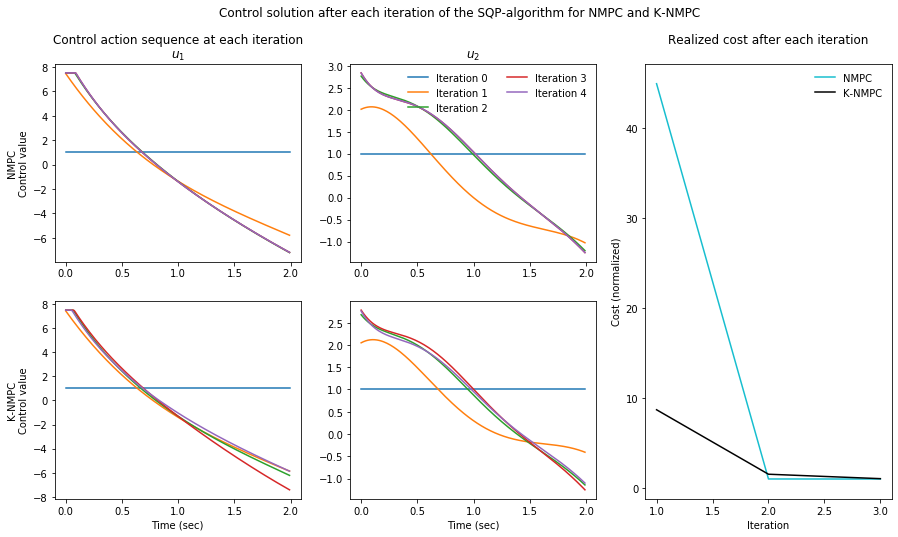

Solution statistics

                        Number of SQP    Mean comp. time per    Std comp. time per    Total comp.
                           iterations       iteration (secs)      iteration (secs)    time (secs)
--------------------  ---------------  ---------------------  --------------------  -------------
Nonlinear MPC                       4              0.0248144            0.00192101      0.0992577
Koopman bilinear MPC               50              0.0137213            0.00606779      0.686067


In [12]:
n_iter = min(len(controller_nmpc.x_iter),len(controller_knmpc.x_iter))

# Calculate cost after each iteration:
iter_cost_nmpc, iter_cost_knmpc = [], []

ol_controller_init = OpenLoopController(finite_dim_koop_sys, u_init, t_eval[:-1])
xs_init, _ = finite_dim_koop_sys.simulate(x0, ol_controller_init, t_eval)
xs_init, us_init = xs_init.T, u_init.T
init_cost = (xs_init[:,-1]-set_pt).T@QN_mpc@(xs_init[:,-1]-set_pt) + np.sum(np.diag(us_init.T@R_mpc@us_init))
iter_cost_nmpc = [init_cost]
iter_cost_knmpc = [init_cost]

for ii in range(n_iter):
    ur_knmpc_iter = controller_knmpc.u_iter[ii].T
    ol_controller_knmpc_iter = OpenLoopController(finite_dim_koop_sys, ur_knmpc_iter, t_eval[:-1])
    xs_knmpc_iter, _ = finite_dim_koop_sys.simulate(x0, ol_controller_knmpc_iter, t_eval)
    xs_knmpc_iter, us_knmpc_iter = xs_knmpc_iter.T, ur_knmpc_iter.T
    iter_cost_knmpc.append((xs_knmpc_iter[:,-1]-set_pt).T@QN_mpc@(xs_knmpc_iter[:,-1]-set_pt) + np.sum(np.diag(us_knmpc_iter.T@R_mpc@us_knmpc_iter)))
    
    ur_nmpc_iter = controller_nmpc.u_iter[ii].T
    ol_controller_nmpc_iter = OpenLoopController(finite_dim_koop_sys, ur_nmpc_iter, t_eval[:-1])
    xs_nmpc_iter, _ = finite_dim_koop_sys.simulate(x0, ol_controller_nmpc_iter, t_eval)
    xs_nmpc_iter, us_nmpc_iter = xs_nmpc_iter.T, ur_nmpc_iter.T
    iter_cost_nmpc.append((xs_nmpc_iter[:,-1]-set_pt).T@QN_mpc@(xs_nmpc_iter[:,-1]-set_pt) + np.sum(np.diag(us_nmpc_iter.T@R_mpc@us_nmpc_iter)))

plt.figure(figsize=(15,8))
plt.suptitle('Control solution after each iteration of the SQP-algorithm for NMPC and K-NMPC')
ax1 = plt.subplot(2,3,1)
ax1.plot(t_eval[:-1],u_init[:, 0])
ax2 = plt.subplot(2,3,2)
ax2.plot(t_eval[:-1],u_init[:, 1], label='Iteration 0')
ax3 = plt.subplot(2,3,4)
ax3.plot(t_eval[:-1],u_init[:, 0])
ax4 = plt.subplot(2,3,5)
ax4.plot(t_eval[:-1],u_init[:, 0])

for it in range(n_iter):
    ax1.plot(t_eval[:-1],controller_nmpc.u_iter[it][0,:])
    ax2.plot(t_eval[:-1],controller_nmpc.u_iter[it][1,:], label='Iteration '+str(it+1))
    ax3.plot(t_eval[:-1],controller_knmpc.u_iter[it][0,:])
    ax4.plot(t_eval[:-1],controller_knmpc.u_iter[it][1,:])
    
ax5 = plt.subplot(1,3,3)
ax5.plot(np.arange(1,n_iter), iter_cost_nmpc[1:n_iter]/iter_cost_nmpc[-1], 'tab:cyan', label='NMPC')
ax5.plot(np.arange(1,n_iter), iter_cost_knmpc[1:n_iter]/iter_cost_nmpc[-1], 'k', label='K-NMPC')

ax1.set_title('Control action sequence at each iteration\n$u_1$')
ax1.set_ylabel('NMPC\nControl value')
ax2.set_title('$u_2$')
ax2.legend(ncol=2, loc='upper right', frameon=False)
ax3.set_ylabel('K-NMPC\nControl value')
ax3.set_xlabel('Time (sec)')
ax4.set_xlabel('Time (sec)')
ax5.set_title('Realized cost after each iteration\n')
ax5.set_xlabel('Iteration')
ax5.set_ylabel('Cost (normalized)')
ax5.legend(loc='upper right', frameon=False)

plt.show()

print('Solution statistics\n')
print(tabulate([['Nonlinear MPC', len(controller_nmpc.x_iter), np.mean(controller_nmpc.comp_time), np.std(controller_nmpc.comp_time), sum(controller_nmpc.comp_time)],
                ['Koopman bilinear MPC', len(controller_knmpc.x_iter), np.mean(controller_knmpc.comp_time), np.std(controller_knmpc.comp_time), sum(controller_knmpc.comp_time)]], 
               headers=['Number of SQP\niterations','Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)', 'Total comp.\ntime (secs)']))

# Evaluate performance of controllers for closed-loop control

#### Design finite horizon controllers

In [13]:
Q_mpc_cl = 1e2*np.diag([1, 1, 2e-1, 2e-1])
QN_mpc_cl= Q_mpc_cl
R_mpc_cl = np.eye(m)
traj_duration = 0.5
N_cl = int(traj_duration/dt)

controller_lmpc_cl = MPCController(linearized_sys, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt, terminal_constraint=False, add_slack=True)
controller_knmpc_cl = BilinearMPCController(kbf_d, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt, terminal_constraint=False, add_slack=True)
controller_knmpc_cl.construct_controller(controller_knmpc.cur_z[:N_cl+1,:], controller_knmpc.cur_u[:N_cl,:])
controller_nmpc_cl = NonlinearMPCController(finite_dim_koop_sys_d, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt, terminal_constraint=False)
controller_nmpc_cl.construct_controller(controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:])

In [14]:
controller_knmpc_cl.solve_to_convergence(z0, 0., controller_knmpc.cur_z[:N_cl+1,:], controller_knmpc.cur_u[:N_cl,:], max_iter=max_iter)
controller_nmpc_cl.solve_to_convergence(x0, 0., controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:], max_iter=max_iter)

#### Simulate designed trajectories closed-loop

In [15]:
xs_lmpc_cl, us_lmpc_cl = finite_dim_koop_sys.simulate(x0, controller_lmpc_cl, t_eval)
xs_lmpc_cl, us_lmpc_cl = xs_lmpc_cl.T, us_lmpc_cl.T

controller_knmpc_cl.comp_time = []
xs_knmpc_cl, us_knmpc_cl = finite_dim_koop_sys.simulate(x0, controller_knmpc_cl, t_eval)
xs_knmpc_cl, us_knmpc_cl = xs_knmpc_cl.T, us_knmpc_cl.T

controller_nmpc_cl.comp_time = []
xs_nmpc_cl, us_nmpc_cl = finite_dim_koop_sys.simulate(x0, controller_nmpc_cl, t_eval)
xs_nmpc_cl, us_nmpc_cl = xs_nmpc_cl.T, us_nmpc_cl.T

[0.00037537 0.00037526 0.0751125  0.07508058]
[0.00150301 0.00150223 0.15045156 0.15034617]
[0.00338516 0.00338291 0.22601695 0.22582993]
[0.0060241  0.00601967 0.30180941 0.30156602]
[0.00942211 0.00941519 0.3778296  0.37758858]
[0.01358146 0.01357251 0.45407818 0.45393183]
[0.01850443 0.01849501 0.53055586 0.53062997]
[0.02419334 0.02418641 0.60726331 0.60771724]
[0.03065047 0.03065077 0.68420125 0.68522798]
[0.03787813 0.03789249 0.76137034 0.76319646]
[0.04587865 0.04591634 0.83877131 0.84165707]
[0.05465434 0.05472739 0.91640496 0.92064413]
[0.06420753 0.06433109 0.99427175 1.0001929 ]
[0.07454055 0.07473323 1.07237253 1.08033609]
[0.08565576 0.08593991 1.15070795 1.16110893]
[0.0975555  0.09795762 1.22927876 1.24254585]
[0.11024212 0.11079316 1.30808562 1.32468123]
[0.123718   0.12445369 1.38712928 1.40754958]
[0.1379855  0.13894671 1.46641043 1.49118548]
[0.153047   0.15428007 1.5459298  1.57562382]
[0.16890489 0.17046197 1.62568809 1.66089832]
[0.18556156 0.18750097 1.70568602 

[0.05465388 0.05472687 0.91639619 0.92063436]
[0.06420697 0.06433047 0.99426212 1.00018125]
[0.0745399  0.07473248 1.072362   1.08032338]
[0.08565499 0.08593903 1.15069652 1.16109517]
[0.09755461 0.0979566  1.22926642 1.24253113]
[0.11024111 0.11079198 1.30807237 1.32466565]
[0.12371685 0.12445235 1.38711509 1.40753325]
[0.1379842  0.13894521 1.46639529 1.49116849]
[0.15304555 0.1542784  1.54591369 1.57560584]
[0.16890327 0.17046011 1.62567101 1.66087987]
[0.18555977 0.1874989  1.70566793 1.74702512]
[0.20301743 0.20540364 1.78590523 1.83407622]
[0.22127868 0.22418356 1.86638361 1.92206774]
[0.24034591 0.24384824 1.94710378 2.01103428]
[0.26022156 0.26440761 2.02806647 2.10101045]
[0.28090805 0.28587193 2.10927242 2.19203088]
[0.30240782 0.30825182 2.19072235 2.28413021]
[0.32472331 0.33155824 2.27241707 2.37734282]
[0.34785698 0.35580251 2.35435717 2.47170387]
[0.37181128 0.38099627 2.43654346 2.56724775]
[0.39658867 0.40715152 2.51897663 2.66400901]
[0.42219164 0.43428062 2.60165749 

[4.61437659 2.9992588  0.66506496 0.01034815]
[4.62097041 2.99936091 0.65369242 0.01007808]
[4.62745147 2.99945972 0.64251462 0.00968763]
[4.63382171 2.99955408 0.63152816 0.00919038]
[4.64008303 2.99964302 0.62072975 0.00860071]
[4.64623729 2.99972567 0.61011613 0.00793347]
[4.65228631 2.99980133 0.59968411 0.00720377]
[0.00037538 0.00037526 0.07511261 0.07508068]
[0.001503   0.00150223 0.1504509  0.15034542]
[0.00338515 0.0033829  0.22601554 0.22582834]
[0.00602407 0.00601963 0.30180722 0.30156356]
[0.00942205 0.00941513 0.37782662 0.37758525]
[0.01358137 0.01357241 0.45407441 0.4539276 ]
[0.0185043  0.01849486 0.53055129 0.53062484]
[0.02419316 0.0241862  0.60725795 0.60771123]
[0.03065023 0.0306505  0.68419507 0.68522104]
[0.03787783 0.03789215 0.76136335 0.7631886 ]
[0.04587827 0.04591591 0.83876348 0.84164823]
[0.05465387 0.05472687 0.91639616 0.92063429]
[0.06420697 0.06433046 0.99426209 1.00018118]
[0.0745399  0.07473248 1.07236197 1.08032331]
[0.08565499 0.08593903 1.1506965  

[ 4.50887622e+00  2.99825897e+00  8.47101114e-01 -1.63779536e-03]
[4.51727478e+00 2.99825129e+00 8.32602483e-01 1.11265863e-04]
[4.52552959e+00 2.99826067e+00 8.18353667e-01 1.77344062e-03]
[4.53364315e+00 2.99828613e+00 8.04350174e-01 3.32738794e-03]
[4.54161787 2.9983265  0.79058761 0.004755  ]
[4.54945615 2.99838044 0.77706169 0.00604146]
[4.55716033 2.99844648 0.7637682  0.00717521]
[4.56473272 2.99852306 0.75070303 0.00814793]
[4.57217558 2.99860854 0.73786215 0.00895441]
[4.57949113 2.99870124 0.72524163 0.00959245]
[4.58668156 2.99879948 0.7128376  0.01006266]
[4.59374901 2.99890161 0.70064626 0.01036823]
[4.60069559 2.99900599 0.68866391 0.01051477]
[4.60752337 2.99911109 0.67688691 0.01051   ]
[4.61423439 2.99921543 0.66531168 0.01036351]
[4.62083065 2.99931766 0.65393471 0.01008646]
[4.62731412 2.99941652 0.64275257 0.00969133]
[4.63368672 2.99951091 0.63176188 0.00919162]
[4.63995035 2.99959986 0.62095931 0.00860155]
[4.64610688 2.99968252 0.61034163 0.00793585]
[4.65215814 

#### Plot/analyze the results

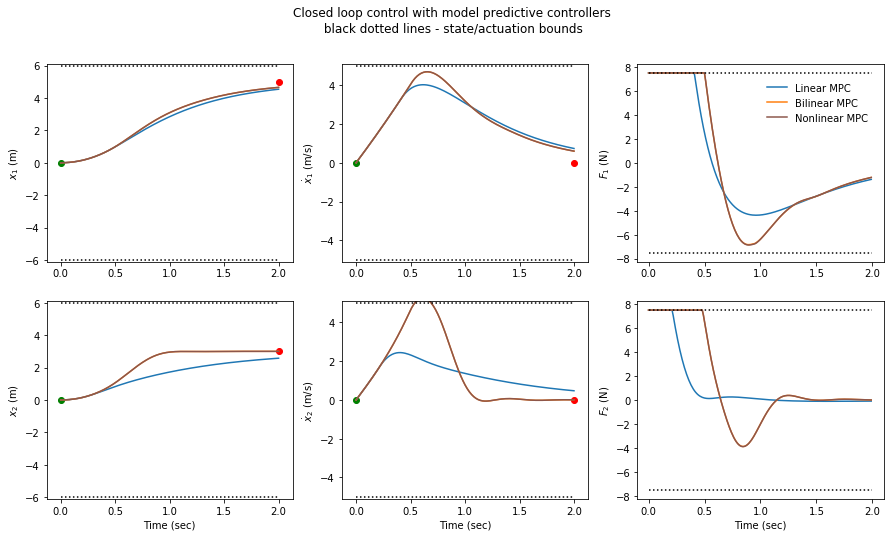


Solution statistics:

                        Quadratic cost    Mean comp. time per    Std comp. time per
                          (normalized)       iteration (secs)      iteration (secs)
--------------------  ----------------  ---------------------  --------------------
Linear MPC                    1.23879              0.0002741            7.11432e-05
Koopman bilinear MPC          0.998959             0.00204425           0.000218696
Nonlinear MPC                 1                    0.00681379           0.000657276


In [16]:
plot_inds = [0, 2, 1, 3, 0, 1]
subplot_inds = [1, 2, 4, 5, 3, 6]
labels = ['$x_1$ (m)', '$x_2$ (m)', '$\\dot{x}_1$ (m/s)','$\\dot{x}_2$ (m/s)','$F_1$ (N)','$F_2$ (N)']
colors = ['tab:blue', 'tab:orange', 'tab:brown']

plt.figure(figsize=(15,8))
plt.suptitle('Closed loop control with model predictive controllers\n black dotted lines - state/actuation bounds')
for ii in range(6):
    ind = plot_inds[ii]
    if ii < 4:
        plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval, xs_lmpc_cl[ind,:], colors[0], label='Linear MPC')
        plt.plot(t_eval, xs_knmpc_cl[ind, :], colors[1], label='Bilinear MPC')
        plt.plot(t_eval, xs_nmpc_cl[ind,:], colors[2], label='Nonlinear MPC')
        
        #plt.plot(t_eval, xr_lmpc[ind,:], '--', color=colors[0], linewidth=1)
        #plt.plot(t_eval, xr_knmpc[ind, :], '--', color=colors[1], linewidth=1)
        #plt.plot(t_eval, xr_nmpc[ind,:], '--', color=colors[2], linewidth=1)

        plt.plot([0, 2.], [xmax[ind], xmax[ind]], ':k')
        plt.plot([0, 2.], [xmin[ind], xmin[ind]], ':k')
        plt.scatter(t_eval[0], x0[ind], color='g')
        plt.scatter(t_eval[-1], set_pt[ind], color='r')
        plt.ylabel(labels[ind])
        plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
    else:
        ax = plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval[:-1],us_lmpc_cl[ind,:], color=colors[0], label='Linear MPC')
        plt.plot(t_eval[:-1], us_knmpc_cl[ind, :], color=colors[1], label='Bilinear MPC')
        plt.plot(t_eval[:-1],us_nmpc_cl[ind,:], color=colors[2], label='Nonlinear MPC')
        plt.plot([0, 2.], [umax[ind], umax[ind]], ':k')
        plt.plot([0, 2.], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if subplot_inds[ii]==3:
            plt.legend(loc='upper right', bbox_to_anchor=(0.975, 0.95), frameon=False)
    if subplot_inds[ii] == 4 or subplot_inds[ii] == 5 or subplot_inds[ii] == 6:
        plt.xlabel('Time (sec)')
            
plt.show()

cost_cl_lmpc = np.sum(np.diag((xs_lmpc_cl[:,:-1]-set_pt.reshape(-1,1)).T@Q_mpc@(xs_lmpc_cl[:,:-1]-set_pt.reshape(-1,1)))) + (xs_lmpc_cl[:,-1]-set_pt).T@QN_mpc@(xs_lmpc_cl[:,-1]-set_pt) + np.sum(np.diag(us_lmpc_cl.T@R_mpc@us_lmpc_cl))
cost_cl_knmpc = np.sum(np.diag((xs_knmpc_cl[:,:-1]-set_pt.reshape(-1,1)).T@Q_mpc@(xs_knmpc_cl[:,:-1]-set_pt.reshape(-1,1)))) + (xs_knmpc_cl[:,-1]-set_pt).T@QN_mpc@(xs_knmpc_cl[:,-1]-set_pt) + np.sum(np.diag(us_knmpc_cl.T@R_mpc@us_knmpc_cl))
cost_cl_nmpc = np.sum(np.diag((xs_nmpc_cl[:,:-1]-set_pt.reshape(-1,1)).T@Q_mpc@(xs_nmpc_cl[:,:-1]-set_pt.reshape(-1,1)))) + (xs_nmpc_cl[:,-1]-set_pt).T@QN_mpc@(xs_nmpc_cl[:,-1]-set_pt) + np.sum(np.diag(us_nmpc_cl.T@R_mpc@us_nmpc_cl))


print('\nSolution statistics:\n')
print(tabulate([['Linear MPC', cost_cl_lmpc/cost_cl_nmpc, np.mean(controller_lmpc_cl.comp_time), np.std(controller_lmpc_cl.comp_time)],
                ['Koopman bilinear MPC', cost_cl_knmpc/cost_cl_nmpc, np.mean(controller_knmpc_cl.comp_time), np.std(controller_knmpc_cl.comp_time)], 
                ['Nonlinear MPC', cost_cl_nmpc/cost_cl_nmpc, np.mean(controller_nmpc_cl.comp_time), np.std(controller_nmpc_cl.comp_time)]],
               headers=['Quadratic cost\n(normalized)', 'Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)']))